<a href="https://colab.research.google.com/github/nishantbala/twitter-sentiment-analysis/blob/master/sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Predictor**
## **Import the libraries, load dataset, print shape of data, data description**

In [1]:
!pip install contractions
!pip install autocorrect
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import WhitespaceTokenizer           # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from sklearn.metrics import accuracy_score

from autocorrect import Speller

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load dataset
train = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/train.csv?raw=true')
test = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/test.csv?raw=true')

In [3]:
#print shape

train.shape

(31962, 3)

In [4]:
#train data first 5 data
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
#train data description
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


## **Data pre-processing**
### Drop all other columns except “tweet” and “label”

In [6]:
trimmed_data = train.copy(deep=True)
for col in train.columns:
  if (col != 'tweet' and col != 'label'):
    trimmed_data.drop([col], axis=1, inplace=True)
trimmed_data.shape
trimmed_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [7]:
# Remove mentions (twitter handle names eg: @user) from the sentence
def remove_mentions(words):
    return " ".join(filter(lambda x:x[0]!='@', words.split()))

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_mentions(x))
trimmed_data.head()

,label,tweet
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation


### Tokenization of tweets

In [8]:
Tokenizer=WhitespaceTokenizer()
trimmed_data['tweet'] = trimmed_data.apply(lambda row: Tokenizer.tokenize(row['tweet']), axis=1)
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, u, take, with, u, all, the, ..."
4,0,"[factsguide:, society, now, #motivation]"


### Replace contractions

In [9]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    new_words = []
    for word in text:
      new_word = contractions.fix(word)
      if new_word != '':
        new_words.append(new_word)
    return new_words

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: replace_contractions(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, cannot, use, b..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, you, take, with, you, all, t..."
4,0,"[factsguide:, society, now, #motivation]"


### Remove punctuations

In [10]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_punctuation(x))        

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Convert to lowercase

In [11]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: to_lowercase(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Stemming

In [12]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: lemmatize_list(x))    
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, be, dysfunctional, and, be, ..."
1,0,"[thank, for, lyft, credit, i, cannot, use, bec..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Autocorrect for misspelt words

In [13]:
spell = Speller(lang='en')
def autospell(words):
  new_words = []
  for word in words:
      new_word = spell(word)
      new_words.append(new_word)
  return new_words
  
#trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: autospell(x))
#trimmed_data.head()

### Normalize words

In [14]:
def normalize(words):   
    return ' '.join(words)
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: normalize(x))
trimmed_data.head()

,label,tweet
0,0,when a father be dysfunctional and be so selfi...
1,0,thank for lyft credit i cannot use because the...
2,0,bihday your majesty
3,0,model i love you take with you all the time in...
4,0,factsguide society now motivation


In [15]:
data_for_countVectorizer = trimmed_data.copy(deep=True)
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

ct_vectorizer = CountVectorizer(max_features=2000)                # Keep only 1000 features as number of features will increase the processing time.
cv_data_features = ct_vectorizer.fit_transform(data_for_countVectorizer['tweet'])
cv_data_features = cv_data_features.toarray()                        # Convert the data features to array.
print(cv_data_features)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [16]:
cv_data_features.shape

(31962, 2000)

In [17]:
labels = data_for_countVectorizer['label']
labels = labels.astype('int')
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64


In [18]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cv_data_features, labels, test_size=0.3, random_state=13)

In [19]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

cv_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

cv_forest = cv_forest.fit(X_train, y_train)

print(cv_forest)

print(np.mean(cross_val_score(cv_forest, cv_data_features, labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.9564170082011334


In [20]:
# Predict the result for test data using the model built above.
cv_result = cv_forest.predict(X_test)
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, cv_result)

print(conf_mat)

[[8911   43]
 [ 330  305]]


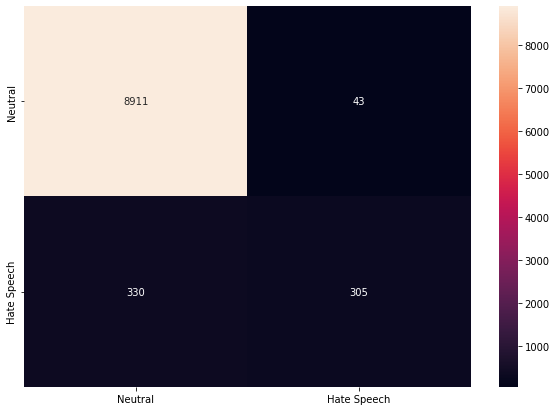

In [21]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [22]:
print('The accuracy score of the predicted model using CountVectorizer is: ', round(accuracy_score(y_test, cv_result),2)) 

The accuracy score of the predicted model using CountVectorizer is:  0.96


In [24]:
# TfidfVectorizer
data_for_TfidfVectorizer = trimmed_data.copy(deep=True)
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

t_vectorizer = TfidfVectorizer(max_features=2000)
tv_data_features = t_vectorizer.fit_transform(data_for_TfidfVectorizer['tweet'])

tv_data_features = tv_data_features.toarray()

tv_data_features.shape

(31962, 2000)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(tv_data_features, labels, test_size=0.3, random_state=42)

In [26]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np
tv_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
tv_forest = tv_forest.fit(X_train, y_train)
print(tv_forest)
print(np.mean(cross_val_score(tv_forest, tv_data_features, labels, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.9563543908302645


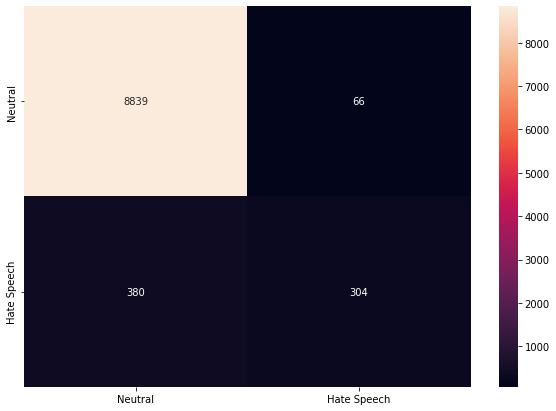

In [27]:
tv_result = tv_forest.predict(X_test)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, tv_result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')